### Imports

In [ ]:
import numpy as np
import itertools, os
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Tuple, List
from scipy.stats import ttest_rel, wilcoxon

### Definitions

In [ ]:
class QuantumDataGenerator:
    def __init__(self, n_qubits: int, dataset_size: int, shots_per_setting: int = 1000, noise_coefficient: float = 2e-3, seed: int = None, temp_dir: str = "temp_data"):
        self.n_qubits = n_qubits
        self.dataset_size = dataset_size
        self.shots_per_setting = shots_per_setting
        self.noise_coefficient = noise_coefficient
        self.dim = 2 ** n_qubits
        self.temp_dir = temp_dir
        os.makedirs(temp_dir, exist_ok=True)

        if seed is not None: np.random.seed(seed)

        if n_qubits >= 5:
            all_settings = list(itertools.product(['Z', 'X', 'Y'], repeat=n_qubits))

            if n_qubits <= 3:
                n_sample_settings = len(all_settings)
            elif n_qubits == 4:
                n_sample_settings = min(200, len(all_settings))
            elif n_qubits == 5:
                n_sample_settings = min(150, len(all_settings))
            elif n_qubits == 6:
                n_sample_settings = min(120, len(all_settings))
            else:
                n_sample_settings = min(4 * n_qubits**2, len(all_settings))

            if n_sample_settings < len(all_settings):
                indices = np.random.choice(len(all_settings), size=n_sample_settings, replace=False)
                self.measurement_settings = [all_settings[i] for i in indices]
            else:
                self.measurement_settings = all_settings
        else:
            self.measurement_settings = list(itertools.product(['Z', 'X', 'Y'], repeat=n_qubits))

        self.n_settings = len(self.measurement_settings)
        self.single_qubit_gates = {
            'Z': np.array([[1, 0], [0, 1]], dtype=complex),
            'X': np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2),
            'Y': np.array([[1, -1j], [1, 1j]], dtype=complex) / np.sqrt(2)
        }
        self._precompute_transformation_indices()

    def generate_random_state(self) -> np.ndarray:
        real_parts = np.random.normal(0, 1, self.dim)
        imag_parts = np.random.normal(0, 1, self.dim)
        amplitudes = real_parts + 1j * imag_parts
        return amplitudes / np.sqrt(np.sum(np.abs(amplitudes)**2))

    def apply_basis_transformation(self, state: np.ndarray, setting: Tuple[str, ...]) -> np.ndarray:
        U = self.transformation_maps[setting]
        return U @ state

    def compute_probabilities(self, transformed_state: np.ndarray) -> np.ndarray:
        return np.abs(transformed_state) ** 2

    def add_shot_noise(self, probabilities: np.ndarray) -> np.ndarray:
        probabilities /= np.sum(probabilities)
        counts = np.random.multinomial(self.shots_per_setting, probabilities)
        noisy_probs = counts / self.shots_per_setting

        if self.noise_coefficient > 0:
            noise = np.random.normal(0, self.noise_coefficient, len(probabilities))
            noisy_probs = np.clip(noisy_probs + noise, 0, None)
            noisy_probs /= np.sum(noisy_probs)

        return noisy_probs.astype(np.float32)

    def sample_generator(self):
        for _ in range(self.dataset_size):
            state = self.generate_random_state()

            all_probabilities = []
            for setting in self.measurement_settings:
                transformed_state = self.apply_basis_transformation(state, setting)
                probs = self.compute_probabilities(transformed_state)
                noisy_probs = self.add_shot_noise(probs)
                all_probabilities.append(noisy_probs)

            features = np.concatenate(all_probabilities)
            labels = np.concatenate([state.real, state.imag])
            yield features.astype(np.float32), labels.astype(np.float32)

    def generate_memmap_dataset(self) -> Tuple[np.memmap, np.memmap]:
        feature_dim = self.n_settings * self.dim
        label_dim = 2 * self.dim

        features_path = os.path.join(self.temp_dir, 'features.dat')
        labels_path = os.path.join(self.temp_dir, 'labels.dat')

        features = np.memmap(features_path, dtype=np.float32, mode='w+', shape=(self.dataset_size, feature_dim))
        labels = np.memmap(labels_path, dtype=np.float32, mode='w+', shape=(self.dataset_size, label_dim))

        for i, (feat, lab) in tqdm(enumerate(self.sample_generator()), total=self.dataset_size, desc="Generating dataset"):
            features[i] = feat
            labels[i] = lab
            if (i+1) % 100 == 0:
                features.flush()
                labels.flush()

        return features, labels

    def batched_generator(self, batch_size: int = 32):
        for i in tqdm(range(0, self.dataset_size, batch_size), desc="Generating batches"):
            batch_X = []
            batch_y = []
            for _ in range(min(batch_size, self.dataset_size - i)):
                features, labels = next(self.sample_generator())
                batch_X.append(features)
                batch_y.append(labels)
            yield np.array(batch_X), np.array(batch_y)

    def _precompute_transformation_indices(self):
        self.transformation_maps = {}

        for setting in self.measurement_settings:
            perm = []
            inv_perm = list(range(self.n_qubits))

            gates = [self.single_qubit_gates[b] for b in setting]
            total_matrix = gates[0]
            for i in range(1, self.n_qubits):
                total_matrix = np.kron(total_matrix, gates[i])

            self.transformation_maps[setting] = total_matrix

In [ ]:
class QuantumStateNN(nn.Module):
    def __init__(self, input_dim: int, state_dim: int, hidden_dims: list = [1024, 512, 256], lambda_l1: float = 5e-5):
        super().__init__()
        self.state_dim = state_dim
        self.lambda_l1 = lambda_l1

        layers = []
        prev_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.SiLU(),
                nn.Dropout(0.2 if i == 0 else 0.3)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 2 * state_dim))
        self.network = nn.Sequential(*layers)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity='leaky_relu')
                nn.init.zeros_(module.bias)

    def get_regularization_loss(self):
        l1_loss = 0.0

        for module in self.modules():
            if isinstance(module, nn.Linear):
                if self.lambda_l1 > 0:
                    l1_loss += torch.sum(torch.abs(module.weight))

        return self.lambda_l1 * l1_loss

    def forward(self, x):
        raw_output = self.network(x)

        real_parts = raw_output[:, :self.state_dim]
        imag_parts = raw_output[:, self.state_dim:]

        complex_amps = real_parts + 1j * imag_parts
        norms = torch.sqrt(torch.sum(torch.abs(complex_amps) ** 2, dim=1, keepdim=True))
        normalized_amps = complex_amps / (norms + 1e-8)

        return torch.cat([normalized_amps.real, normalized_amps.imag], dim=1)

def compute_fidelity(pred, target, state_dim):
    pred_complex = pred[:, :state_dim] + 1j * pred[:, state_dim:]
    target_complex = target[:, :state_dim] + 1j * target[:, state_dim:]
    inner_products = torch.sum(torch.conj(target_complex) * pred_complex, dim=1)
    return torch.mean(torch.abs(inner_products) ** 2)

def train_model(x_train, y_train, x_val, y_val, state_dim, epochs=64, batch_size=32, lr=2e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = TensorDataset(
        torch.tensor(x_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )
    val_dataset = TensorDataset(
        torch.tensor(x_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = QuantumStateNN(input_dim=x_train.shape[1], state_dim=state_dim, lambda_l1=1e-5).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=6e-3)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.75)

    l1_criterion = nn.L1Loss()

    def combined_loss(pred, target):
        l1_loss = l1_criterion(pred, target)
        fidelity = compute_fidelity(pred, target, state_dim)
        fidelity_loss = 1.0 - fidelity
        base_loss = 0.3 * l1_loss + 0.7 * fidelity_loss

        reg_loss = model.get_regularization_loss()

        return base_loss + reg_loss

    train_losses, val_losses = [], []
    train_fidelities, val_fidelities = [], []

    best_val_fidelity = 0.0
    patience = 0

    pbar = tqdm(range(epochs), desc="Training epochs", leave=False)
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        train_fid = 0.0

        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            pred = model(batch_x)
            loss = combined_loss(pred, batch_y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.5)

            optimizer.step()

            train_loss += loss.item()
            train_fid += compute_fidelity(pred, batch_y, state_dim).item()

        model.eval()
        val_loss = 0.0
        val_fid = 0.0

        with torch.no_grad():
            for batch_x, batch_y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                val_loss += combined_loss(pred, batch_y).item()
                val_fid += compute_fidelity(pred, batch_y, state_dim).item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_fidelities.append(train_fid / len(train_loader))
        val_fidelities.append(val_fid / len(val_loader))

        pbar.set_postfix({
            "Train loss": f" {train_losses[-1]:.4f}",
            "Val loss": f" {val_losses[-1]:.4f}",
            "Val fide": f" {val_fidelities[-1]:.4f}"
        })

        scheduler.step()

        if val_fidelities[-1] > best_val_fidelity:
            best_val_fidelity = val_fidelities[-1]
            patience = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience += 1

        # if patience >= 8:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

    model.load_state_dict(torch.load('best_model.pth'))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train Loss', alpha=0.8)
    ax1.plot(val_losses, label='Val Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_fidelities, label='Train Fidelity', alpha=0.8)
    ax2.plot(val_fidelities, label='Val Fidelity', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fidelity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model

In [ ]:
from time import time
def construct_measurement_operators(n_qubits, measurement_settings):
    pauli_matrices = {
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex),
        'I': np.array([[1, 0], [0, 1]], dtype=complex)
    }

    measurement_ops = []
    for setting in measurement_settings:
        op = pauli_matrices[setting[0]]
        for i in range(1, n_qubits):
            op = np.kron(op, pauli_matrices[setting[i]])
        measurement_ops.append(op)

    return measurement_ops

def construct_projector_basis(n_qubits):
    dim = 2**n_qubits
    projectors = []

    for j in range(dim):
        proj = np.zeros((dim, dim), dtype=complex)
        proj[j, j] = 1.0
        projectors.append(proj)

    return projectors

def least_squares_tomography(X, state_dim, n_settings):
    n_qubits = int(np.log2(state_dim))
    outcome_dim = X.shape[1] // n_settings

    measurement_settings = []
    for i in range(n_settings):
        setting = tuple(np.random.choice(['X', 'Y', 'Z'], n_qubits))
        measurement_settings.append(setting)

    A_list = []
    projectors = construct_projector_basis(n_qubits)

    for setting_idx in range(n_settings):
        for outcome_idx in range(outcome_dim):
            proj = projectors[outcome_idx]
            proj_vec = proj.flatten()
            A_list.append(proj_vec)

    A = np.array(A_list)

    reconstructed = []
    for sample in X:
        measurements = sample

        try:
            rho_vec = np.linalg.lstsq(A, measurements, rcond=None)[0]
            rho_matrix = rho_vec.reshape(state_dim, state_dim)

            rho_matrix = (rho_matrix + rho_matrix.conj().T) / 2
            eigvals, eigvecs = np.linalg.eigh(rho_matrix)
            eigvals = np.maximum(eigvals, 0)
            eigvals = eigvals / np.sum(eigvals)
            rho_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T

            eigvals, eigvecs = np.linalg.eigh(rho_matrix)
            max_idx = np.argmax(eigvals)
            state_vector = eigvecs[:, max_idx]

            state_vector = state_vector / np.sqrt(np.sum(np.abs(state_vector)**2))

        except np.linalg.LinAlgError:
            state_vector = np.random.randn(state_dim) + 1j * np.random.randn(state_dim)
            state_vector = state_vector / np.sqrt(np.sum(np.abs(state_vector)**2))

        reconstructed.append(np.concatenate([state_vector.real, state_vector.imag]))

    return np.array(reconstructed)

def maximum_likelihood_tomography(X, state_dim, n_settings):
    n_qubits = int(np.log2(state_dim))
    outcome_dim = X.shape[1] // n_settings

    projectors = construct_projector_basis(n_qubits)

    reconstructed = []
    for sample in X:
        probs = sample.reshape(n_settings, outcome_dim)

        rho = np.eye(state_dim, dtype=complex) / state_dim

        max_iterations = 50
        tolerance = 1e-6

        for iteration in range(max_iterations):
            rho_old = rho.copy()

            R = np.zeros((state_dim, state_dim), dtype=complex)

            for setting_idx in range(n_settings):
                for outcome_idx in range(outcome_dim):
                    proj = projectors[outcome_idx]
                    observed_prob = probs[setting_idx, outcome_idx]
                    expected_prob = np.real(np.trace(proj @ rho))

                    if expected_prob > 1e-12:
                        R += (observed_prob / expected_prob) * proj

            rho = R @ rho @ R.conj().T
            rho = rho / np.trace(rho)

            if np.linalg.norm(rho - rho_old, 'fro') < tolerance:
                break

        eigvals, eigvecs = np.linalg.eigh(rho)
        max_idx = np.argmax(eigvals)
        state_vector = eigvecs[:, max_idx]

        state_vector = state_vector / np.sqrt(np.sum(np.abs(state_vector)**2))

        reconstructed.append(np.concatenate([state_vector.real, state_vector.imag]))

    return np.array(reconstructed)

def linear_inversion_tomography(X, state_dim, n_settings):
    n_qubits = int(np.log2(state_dim))
    outcome_dim = X.shape[1] // n_settings

    pauli_1q = [
        np.array([[1, 0], [0, 1]], dtype=complex),
        np.array([[0, 1], [1, 0]], dtype=complex),
        np.array([[0, -1j], [1j, 0]], dtype=complex),
        np.array([[1, 0], [0, -1]], dtype=complex)
    ]

    pauli_basis = []
    for indices in itertools.product(range(4), repeat=n_qubits):
        pauli_op = pauli_1q[indices[0]]
        for i in range(1, n_qubits):
            pauli_op = np.kron(pauli_op, pauli_1q[indices[i]])
        pauli_basis.append(pauli_op / np.sqrt(state_dim))

    projectors = construct_projector_basis(n_qubits)

    transfer_matrix = []
    for setting_idx in range(n_settings):
        for outcome_idx in range(outcome_dim):
            proj = projectors[outcome_idx]
            row = []
            for pauli_op in pauli_basis:
                expectation = np.real(np.trace(proj @ pauli_op))
                row.append(expectation)
            transfer_matrix.append(row)

    transfer_matrix = np.array(transfer_matrix)

    reconstructed = []
    for sample in X:
        pauli_coeffs = np.linalg.lstsq(transfer_matrix, sample, rcond=None)[0]

        rho = np.zeros((state_dim, state_dim), dtype=complex)
        for i, coeff in enumerate(pauli_coeffs):
            rho += coeff * pauli_basis[i]

        rho = (rho + rho.conj().T) / 2
        eigvals, eigvecs = np.linalg.eigh(rho)
        eigvals = np.maximum(eigvals, 0)
        eigvals = eigvals / np.sum(eigvals)
        rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T

        max_idx = np.argmax(eigvals)
        state_vector = eigvecs[:, max_idx]
        state_vector = state_vector / np.sqrt(np.sum(np.abs(state_vector)**2))

        reconstructed.append(np.concatenate([state_vector.real, state_vector.imag]))

    return np.array(reconstructed)

def compute_fidelities(predictions, y_test, state_dim):
    pred_complex = predictions[:, :state_dim] + 1j * predictions[:, state_dim:]
    true_complex = y_test[:, :state_dim] + 1j * y_test[:, state_dim:]
    inner_products = np.sum(np.conj(true_complex) * pred_complex, axis=1)
    return np.abs(inner_products) ** 2

def evaluate_model(model, x_test, y_test, state_dim, n_settings):
    device = next(model.parameters()).device
    model.eval()

    nn_start_time = time()
    with torch.no_grad():
        x_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
        nn_predictions = model(x_tensor).cpu().numpy()
    nn_time = time() - nn_start_time

    ls_start_time = time()
    ls_predictions = least_squares_tomography(x_test, state_dim, n_settings)
    ls_time = time() - ls_start_time

    mle_start_time = time()
    mle_predictions = maximum_likelihood_tomography(x_test, state_dim, n_settings)
    mle_time = time() - mle_start_time

    li_start_time = time()
    li_predictions = linear_inversion_tomography(x_test, state_dim, n_settings)
    li_time = time() - li_start_time

    methods = {
        'Neural Network': (nn_predictions, nn_time),
        'Least Squares': (ls_predictions, ls_time),
        'Max Likelihood': (mle_predictions, mle_time),
        'Linear Inversion': (li_predictions, li_time)
    }

    results = {}

    for method_name, (predictions, exec_time) in tqdm(methods.items(), desc="Evaluating methods"):
        pred_complex = predictions[:, :state_dim] + 1j * predictions[:, state_dim:]
        true_complex = y_test[:, :state_dim] + 1j * y_test[:, state_dim:]

        inner_products = np.sum(np.conj(true_complex) * pred_complex, axis=1)
        fidelities = np.abs(inner_products) ** 2

        amp_errors = np.abs(pred_complex - true_complex)
        phase_errors = np.angle(pred_complex) - np.angle(true_complex)
        phase_errors = np.abs(np.angle(np.exp(1j * phase_errors)))
        mse = np.mean((predictions - y_test) ** 2)

        results[method_name] = {
            'mean_fidelity': np.mean(fidelities),
            'std_fidelity': np.std(fidelities),
            'min_fidelity': np.min(fidelities),
            'median_fidelity': np.median(fidelities),
            'mean_amplitude_error': np.mean(amp_errors),
            'max_amplitude_error': np.max(amp_errors),
            'mean_phase_error': np.mean(phase_errors),
            'mse': mse,
            'rmse': np.sqrt(mse),
            'execution_time': exec_time,
            'samples_per_second': len(x_test) / max(exec_time, 1e-6)
        }

    print("\n" + "="*95)
    print("QUANTUM STATE TOMOGRAPHY METHOD COMPARISON")
    print("="*95)
    print(f"{'Method':<15} {'Fidelity':<12} {'±Std':<8} {'Min':<8} {'Amp Error':<10} {'Phase Err':<10} {'Time (s)':<8} {'Samp/s':<8}")
    print("-"*95)

    for method_name, metrics in results.items():
        print(f"{method_name:<15} {metrics['mean_fidelity']:<12.4f} "
              f"{metrics['std_fidelity']:<8.4f} {metrics['min_fidelity']:<8.4f} "
              f"{metrics['mean_amplitude_error']:<10.4f} {metrics['mean_phase_error']:<10.4f} "
              f"{metrics['execution_time']:<8.3f} {metrics['samples_per_second']:<8.1f}")

    nn_fidelities = compute_fidelities(nn_predictions, y_test, state_dim)
    ls_fidelities = compute_fidelities(ls_predictions, y_test, state_dim)
    mle_fidelities = compute_fidelities(mle_predictions, y_test, state_dim)

    print("\n" + "-"*60)
    print("STATISTICAL SIGNIFICANCE TESTS (NN vs Classical)")
    print("-"*60)

    _, p_val_ls = ttest_rel(nn_fidelities, ls_fidelities)
    _, p_val_mle = ttest_rel(nn_fidelities, mle_fidelities)

    print(f"NN vs Least Squares      - p-value: {p_val_ls:.4f} {'(significant)' if p_val_ls < 0.05 else '(not significant)'}")
    print(f"NN vs Max Likelihood     - p-value: {p_val_mle:.4f} {'(significant)' if p_val_mle < 0.05 else '(not significant)'}")

    best_fidelity = max([r['mean_fidelity'] for r in results.values()])
    best_method = [k for k, v in results.items() if v['mean_fidelity'] == best_fidelity][0]
    fastest_method = min(results.items(), key=lambda x: x[1]['execution_time'])[0]

    print(f"\nBest Fidelity: {best_method} ({best_fidelity:.4f})")
    print(f"Fastest Method: {fastest_method} ({results[fastest_method]['execution_time']:.3f}s)")

    nn_fid = results['Neural Network']['mean_fidelity']
    ls_fid = results['Least Squares']['mean_fidelity']
    print(f"NN vs Classical (LS): {nn_fid / ls_fid:.2f}x fidelity improvement")

### Train

In [ ]:
N_QUBITS = 4
DATASET_SIZE = 4096
SHOTS_PER_SETTING = 2048
NOISE_COEF = 5e-3
RANDOM_SEED = 21

generator = QuantumDataGenerator(
    n_qubits=N_QUBITS,
    dataset_size=DATASET_SIZE,
    shots_per_setting=SHOTS_PER_SETTING,
    noise_coefficient=NOISE_COEF,
    seed=RANDOM_SEED,
    temp_dir="quantum_data"
)

X, y = generator.generate_memmap_dataset()

print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

real_part = y[0, :generator.dim]
imag_part = y[0, generator.dim:]
sample_state = real_part + 1j * imag_part
norm_squared = np.sum(np.abs(sample_state) ** 2)
print(f"Sample state norm²: {norm_squared:.4f} (should be ~1.0)")

Generating dataset:   0%|          | 0/4096 [00:00<?, ?it/s]

Features shape: (4096, 1296)
Targets shape: (4096, 32)
Sample state norm²: 1.0000 (should be ~1.0)


Training epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

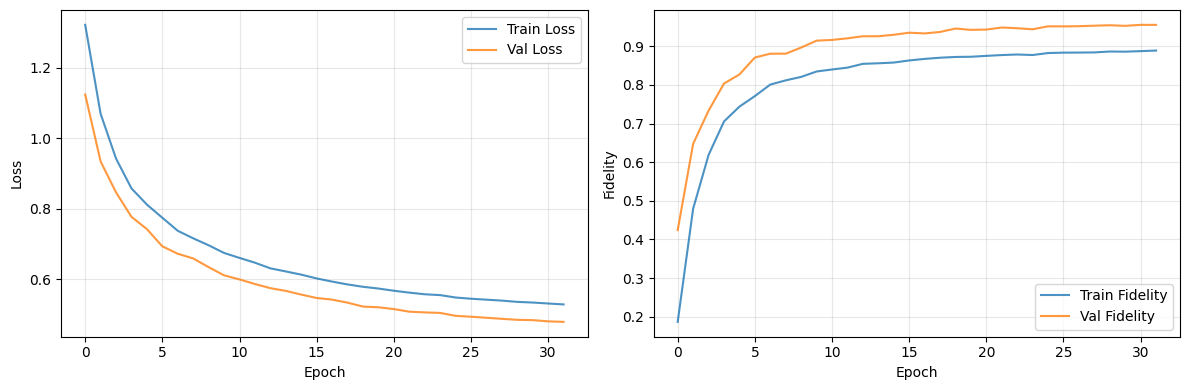

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

STATE_DIM = 2**N_QUBITS
trained_model = train_model(
    x_train, y_train, x_val, y_val,
    state_dim=STATE_DIM,
    epochs=32,
    batch_size=32,
    lr=5e-4
)

### Eval

In [ ]:
evaluate_model(trained_model, x_test, y_test, state_dim=STATE_DIM, n_settings=generator.n_settings)

Evaluating methods:   0%|          | 0/4 [00:00<?, ?it/s]


QUANTUM STATE TOMOGRAPHY METHOD COMPARISON
Method          Fidelity     ±Std     Min      Amp Error  Phase Err  Time (s) Samp/s  
-----------------------------------------------------------------------------------------------
Neural Network  0.9570       0.0893   0.0012   0.2863     1.5704     0.003    127770.6
Least Squares   0.1175       0.0794   0.0008   0.2667     1.5602     20.168   20.3    
Max Likelihood  0.0650       0.0592   0.0002   0.2713     1.5694     438.417  0.9     
Linear Inversion 0.1175       0.0794   0.0008   0.2672     1.5796     13.379   30.6    

------------------------------------------------------------
STATISTICAL SIGNIFICANCE TESTS (NN vs Classical)
------------------------------------------------------------
NN vs Least Squares      - p-value: 0.0000 (significant)
NN vs Max Likelihood     - p-value: 0.0000 (significant)

Best Fidelity: Neural Network (0.9570)
Fastest Method: Neural Network (0.003s)
NN vs Classical (LS): 8.14x fidelity improvement
